# Week 6: Binary Analysis & Symbolic Execution

This lab introduces the core concepts and practices of static malware analysis using Python. While traditional malware analysis often involves virtualised environments and controlled execution of suspicious samples, this lab focuses exclusively on safe, static techniques applied to benign Windows executables from trusted sources.

By the end of this lab, I should be able to:
1. Explain the role of static analysis in malware triage, including its purpose, strengths, and limitations within the broader malware analysis lifecycle.
2. Compute and interpret cryptographic hashes (MD5, SHA1, SHA256) as indicators of compromise, and explain how these identifiers are used in threat intelligence and incident response.
3. Extract and analyse human-readable strings from executable files, identifying potential artefacts such as file paths, registry references, and network indicators.
4. Inspect the structure of Windows PE files using Python, including reading header information, locating entry points, and examining imported libraries and API calls.
5. Detect simple behavioural characteristics using YARA rules, demonstrating how signature-based detection can be applied to classify files or identify suspicious patterns.
6. Conduct a complete static triage workflow, integrating hashing, string analysis, PE inspection, IOC extraction, and YARA matching into a coherent analytical process.
7. Interpret findings and articulate their significance, showing how extracted artefacts contribute to threat assessment, detection opportunities, and future investigation steps.

In [1]:
%pip install pefile yara-python

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 104.2 MB/s  0:00:00

   ---------------------------------------- 2/2 [pefile]

Note: you may need to restart the kernel to use updated packages.


# ProcMon (Process Monitor)

Process Monitor is an advanced monitoring tool for Windows that shows real-time file system, Registry and process/thread activity. It combines the features of two legacy Sysinternals utilities, **Filemon** and **Regmon**, and adds an extensive list of enhancements including rich and non-destructive filtering, comprehensive event properties such as session IDs and user names, reliable process information, full thread stacks with integrated symbol support for each operation, simultaneous logging to a file, and much more. Its uniquely powerful features will make Process Monitor a core utility in your system troubleshooting and malware hunting toolkit.

### FileMon
Filemon (File System Monitor) was a popular, free Microsoft Sysinternals utility for Windows that showed real-time file system activity, helping users track file opens, reads, writes, and deletes to diagnose application issues.

- **Function:** Monitored and displayed all file system activity on a system in real-time.
- **Use Cases:** Diagnosing application problems, understanding how software uses files, and tracking system configurations.
- **Features:** Timestamping events, filtering activity, saving logs, and showing outcomes (success/failure).

### RegMon
RegMon (Registry Monitor) was a classic Sysinternals utility for Windows that showed real-time activity in the Windows Registry, detailing which applications accessed, read, or wrote to specific registry keys, helping with troubleshooting and malware analysis.

- **Real-time Monitoring:** Displayed registry operations as they happened.
- **Detailed Activity:** Showed the process, key path, data, and action (read/write/open) for each event.
- **Filtering:** Allowed users to filter events to focus on specific processes or keys.
- **Troubleshooting:** Excellent for identifying misbehaving applications or malware modifying the registry

Filemon and Regmon were retired by Microsoft in 2009 because their functionality was absorbed and vastly improved by the single, more powerful Process Monitor (ProcMon).

In [12]:
import hashlib

def compute_hash(path, algorithm):
    h = hashlib.new(algorithm)
    with open(path, "rb") as f:
        h.update(f.read())
    return h.hexdigest()

sample = r"..\Week6\samples\Procmon.exe"

print("MD5: ", compute_hash(sample, "md5"))
print("SHA1: ", compute_hash(sample, "sha1"))
print("SHA256:", compute_hash(sample, "sha256"))

MD5:  c3e77b6959cc68baee9825c84dc41d9c
SHA1:  bc18a67ad4057dd36f896a4d411b8fc5b06e5b2f
SHA256: 3b7ea4318c3c1508701102cf966f650e04f28d29938f85d74ec0ec2528657b6e


Interestingly enough, when opening an executable file inside a text editor you can find some readable text in English. Where most other data is complete binary jibberish.

Here is an example of the address and time stamp of when this program was created

```0‚	0“0|10	UUS10U
Washington10URedmond10U
Microsoft Corporation1&0$UMicrosoft Time-Stamp PCA 20103  ð*|Y;æ­   ð0
	`†He  ‚J0	*†H†÷
	1
*†H†÷
	0/	*†H†÷
	1" Y³0W•ýËþM¢*3j¬uç™ÄJÕ±úÎÃE"“=0ú*†H†÷
	/1ê0ç0ä0½ \š£¥rýäS¹€›G¾’êfþÎš²q@eK‹0˜0€¤~0|10	UUS10U
Washington10URedmond10U
Microsoft Corporation1&0$UMicrosoft Time-Stamp PCA 20103  ð*|Y;æ­   ð0" BabZ±kÜ¥bðfÝä²B5a›¼»ŽâcêQÄÞ««p0```

Below I made a copy of the file being looked at and using the text editor I changed 1 single character.

In [13]:
print("These are the hashes for the original file.")
sample = r"..\Week6\samples\Procmon.exe"
print("MD5: ", compute_hash(sample, "md5"))
print("SHA1: ", compute_hash(sample, "sha1"))
print("SHA256:", compute_hash(sample, "sha256"))

print("\nThese are the hashes for the edited file.")
edited_sample = r"..\Week6\samples\Procmon copy.exe"
print("MD5: ", compute_hash(edited_sample, "md5"))
print("SHA1: ", compute_hash(edited_sample, "sha1"))
print("SHA256:", compute_hash(edited_sample, "sha256"))

These are the hashes for the original file.
MD5:  c3e77b6959cc68baee9825c84dc41d9c
SHA1:  bc18a67ad4057dd36f896a4d411b8fc5b06e5b2f
SHA256: 3b7ea4318c3c1508701102cf966f650e04f28d29938f85d74ec0ec2528657b6e

These are the hashes for the edited file.
MD5:  73face0961b82bf39c176d4bb040a702
SHA1:  dd4a52e7204c64ff0346e95a578ad0031ae097da
SHA256: e502c6a239489b35f9c3c121beb0103c0b1f616623481b08f1214d58d2c3eff3


Changing even just one byte in the file (can use a text editor) causes the hash to change completely. This can be called the avelanche effect. In hashing the avelanche effect is a crucial security property where a tiny change in the input (like flipping one bit) causes a massive, seemingly random, and unpredictable change in the entire output hash, ideally flipping about half the output bits.

This diffusion makes hash functions (like SHA-256) resistant to prediction and analysis, preventing attackers from linking similar inputs to similar outputs, thus ensuring strong data integrity and security.

While all the computed hashes in the output above are different, MD5 and SHA1 have a much weaker avelanche effect than SHA256, making hash collisions more common (when two values compute to the same hash) and certain hash behaviour patterns can be predicted.

Hashing is common way of file integrity checking in security. A trojan, a malicious file impersonated a trusted one may flag as harmful by security software which checks the hash 

### Digital Signatures

In fact, if you check the properties of the procmon.exe file, you can find the digital signature done by Microsoft, using the SHA256 hash. Upon uinspecting further details, you can see if the digital signature is ok. As you can see, on the right, the edited Procmon.exe copy failed the integrity check, and the digital signature is not valid.

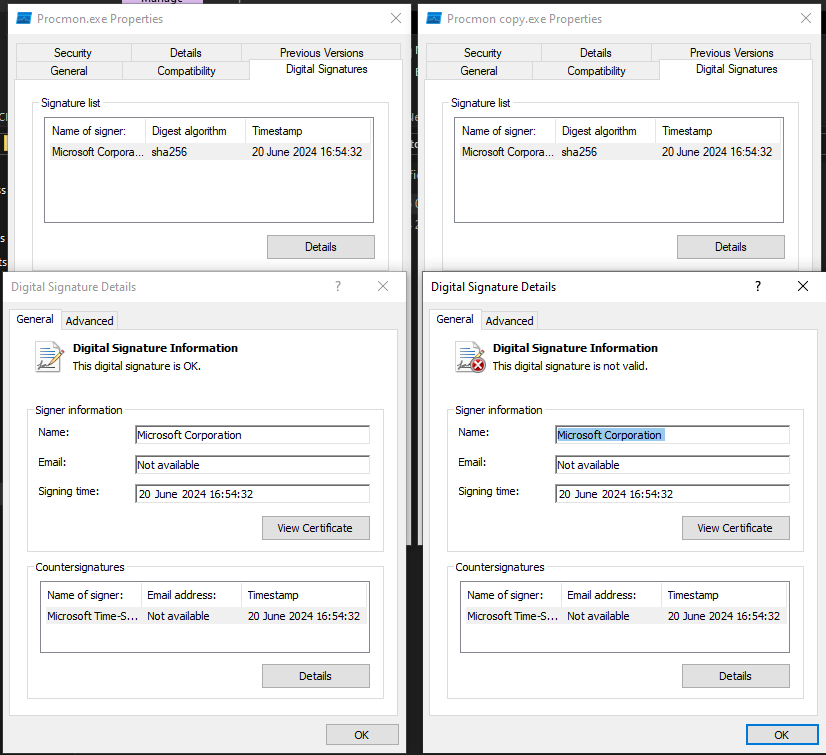

This program also contains a countersignature, which is an additional digital signature applied to an existing signature to provide an extra layer of verification, typically a timestamp. Code-signing certificates have a limited lifespan. The timestamp allows an operating system to verify that the certificate was valid at the time of signing, even if the certificate itself has since expired. This is a layered security practice that provides additional tamper-proofing. 

# String Extraction

As we have already come across before, binary files, including malware, often contain human-readable text.

Analysts review these strings to identify:
- Hardcoded paths
- Registry keys
- Network infrastructure (domains, URLs, IPs)
- Encryption keys or markers
- Persistence mechanisms

Strings provide valuable hints early in the analysis—often before deeper
reverse engineering.

The script below scans the file for printable ASCII sequences of at least four characters. These correspond to readable strings embedded in the executabe file.

In [14]:
import re

def extract_strings(path):
    with open(path, "rb") as f:
        data = f.read()
    pattern = rb"[ -~]{4,}"
    return re.findall(pattern, data)

strings = extract_strings(sample)

for s in strings[:20]:
    print("Extracted string: ", s.decode(errors="ignore")) #ignores errors

Extracted string:  !This program cannot be run in DOS mode.
Extracted string:  V*0T
Extracted string:  0RichU
Extracted string:  .text
Extracted string:  `.rdata
Extracted string:  @.data
Extracted string:  .rsrc
Extracted string:  @.reloc
Extracted string:  hpqQ
Extracted string:  h`EN
Extracted string:  h|nN
Extracted string:  h\nN
Extracted string:  hlnN
Extracted string:  =UUU
Extracted string:  h_rM
Extracted string:  hDLN
Extracted string:  h`GO
Extracted string:  hDLN
Extracted string:  h|GO
Extracted string:  hDLN


For benign tools like Procmon, strings look legitimate:
- DLL names
- Menu labels
- File paths
- Standard Windows messages

In actual malware, this step often reveals:
- Command-and-control domains
- Suspicious temp file names
- Embedded scripts
- Obfuscation artefacts

# PE header inspection using python

Most Windows malware is delivered as a Portable Executable (PE) file.

Learning to read PE headers reveals:
- How the program is structured
- Which libraries it relies on
- Whether the file shows signs of packing or obfuscation
- Possible capabilities (e.g., networking, registry manipulation)

What the script does?
The script loads the PE file and reads:
- **Entry Point:** where execution begins
- **Image Base:** preferred loading address in memory
- **Import Table:** all external functions (APIs) the binary relies on

In [15]:
import pefile

pe = pefile.PE(sample)

print("Entry Point:", hex(pe.OPTIONAL_HEADER.AddressOfEntryPoint))
print("Image Base:", hex(pe.OPTIONAL_HEADER.ImageBase))

print("\nImported DLLs and functions:")
for entry in pe.DIRECTORY_ENTRY_IMPORT:
    print(" ", entry.dll.decode())
    for imp in entry.imports[:5]:
        print(" -", imp.name.decode() if imp.name else "None")

Entry Point: 0xa7f70
Image Base: 0x400000

Imported DLLs and functions:
  WS2_32.dll
 - getsockname
 - listen
 - recv
 - closesocket
 - socket
  VERSION.dll
 - GetFileVersionInfoW
 - VerQueryValueW
 - GetFileVersionInfoSizeW
  COMCTL32.dll
 - ImageList_ReplaceIcon
 - ImageList_SetBkColor
 - ImageList_AddMasked
 - ImageList_BeginDrag
 - ImageList_EndDrag
  FLTLIB.DLL
 - FilterSendMessage
 - FilterGetMessage
 - FilterReplyMessage
 - FilterConnectCommunicationPort
  KERNEL32.dll
 - AcquireSRWLockExclusive
 - AcquireSRWLockShared
 - InitializeSRWLock
 - GetSystemInfo
 - VerSetConditionMask
  USER32.dll
 - LoadStringA
 - DrawEdge
 - GetMessageW
 - TranslateMessage
 - DispatchMessageW
  GDI32.dll
 - SaveDC
 - RestoreDC
 - SetBrushOrgEx
 - SetPixel
 - PatBlt
  COMDLG32.dll
 - ChooseColorW
 - GetOpenFileNameW
 - PrintDlgW
 - ChooseFontW
 - FindTextW
  ADVAPI32.dll
 - RegQueryValueExW
 - ConvertStringSidToSidW
 - ConvertSidToStringSidW
 - RegSetValueW
 - RegEnumKeyW
  SHELL32.dll
 - SHGetSpecia

Procmon imports many legitimate Windows APIs, such as:
- kernel32.dll
- user32.dll
- advapi32.dll

If this were malware, suspicious API imports might include:
- CreateRemoteThread (process injection)
- VirtualAllocEx (shellcode allocation)
- GetProcAddress and LoadLibraryA (dynamic API resolving)
- WinExec or ShellExecuteA (execution of child processes)

# YARA analysis

YARA is a powerful open source tool for malware analysis. It helps cybersecurity experts indentify and classify malware using custom **rules**.

YARA is the primary tool for:
- Writing detection rules
- Identifying malware families
- Matching file characteristics in SOC (Security Operations Centre) pipelines

Analysts use YARA to express signatures based on strings, binary patterns, and structural features.

The script below defines a rule that triggers whenever the string "http" is found. It compiles the rule using yara-python and runs it against the sample file. 

In [16]:
import yara

rule_source = """
rule ContainsHTTP {
    strings:
        $s = "http"
    condition:
        $s
}
"""
rules = yara.compile(source=rule_source)
matches = rules.match(sample)
print(matches)

AttributeError: module 'yara' has no attribute 'compile'

try other softwares, look for anything interesting, anything suspicious. 